In [1]:
import numpy as np
import os 
import re
import random
import pandas as pd
import subprocess
import shutil
import time
import sys

from pymatgen.core import Element
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen.core import Composition
from pymatgen.analysis.structure_matcher import StructureMatcher

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
#print per ogni coppia il ground state e l'entalpia del template che prendo

#Needs df of Individuals, fitness treshold, file gatheredPoscars and return best non duplicated structures (with symm>75)
def best_structures(individuals_df, fitness_upto, all_poscars):
    fitness_gs = individuals_df['fitness'].iloc[0]
    uniques = []
    SGs=[]
    fitness = []
    structure_gs = Poscar.from_str(find_poscar(all_poscars, individuals_df['ID'].iloc[0]))
    
    if (individuals_df['spacegroup'].iloc[0] > 75):
        uniques.append(structure_gs)
        SGs.append(individuals_df['spacegroup'].iloc[0])
        fitness.append(individuals_df['fitness'].iloc[0])

    for i, line_individuals_df in individuals_df.iterrows():
        if line_individuals_df['fitness'] - fitness_gs >= fitness_upto:
            break
        if line_individuals_df['spacegroup'] < 75:
            continue
        new_structure = Poscar.from_str(find_poscar(all_poscars, line_individuals_df['ID']))

        check_dupilcate = False
        
        if StructureMatcher(ltol = 1.0, stol = 1.0, angle_tol = 10, scale=True).fit(structure_gs.structure, new_structure.structure):
            check_dupilcate = True 
        
        for structure in uniques:
            if StructureMatcher(ltol = 1.0, stol = 1.0, angle_tol = 10, scale=True).fit(structure.structure, new_structure.structure):
                check_dupilcate = True
        if not check_dupilcate:
            uniques.append(new_structure)
            SGs.append(line_individuals_df['spacegroup'])
            fitness.append(line_individuals_df['fitness'])
    return uniques, SGs, fitness

def read_individuals(individuals):
    column_names = {0 : "Generation", 1 : "ID", 2 : "GenMode", 
    4 : 'A', 5 : 'B', 7 : "enthalpy", 10 : "fitness", 15 : "spacegroup"}

    individuals = pd.read_csv(individuals, sep="\s+", header=None, skiprows=2,usecols=column_names)
    individuals.rename(columns=column_names, inplace=True)
    individuals.sort_values("fitness", inplace=True)
    return individuals

#Needs in input the name of the file with all the poscars, the id of the structure to be extracted and the name of the output poscar
def find_poscar(all_poscars, id):
    end=-1
    with open(all_poscars,'r') as file:
        testo_input = file.readlines()              
    for i, line in enumerate(testo_input):
        if line.startswith('EA'+str(id)):   
            init = i
            simm=int(line[line.find(':')+1:])
        if line.startswith('EA'+str(id+1)):
            end = i-1
            break
    if end == -1:                            
        end = len(testo_input)-1
        
    poscar_str=''
    for i in range(end-init+1):
        poscar_str+=testo_input[init+i]
    return poscar_str

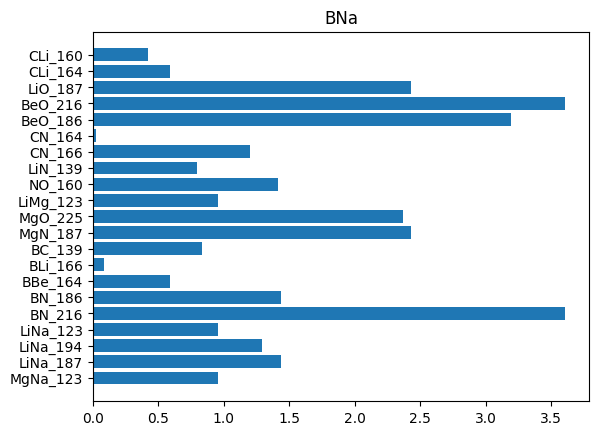

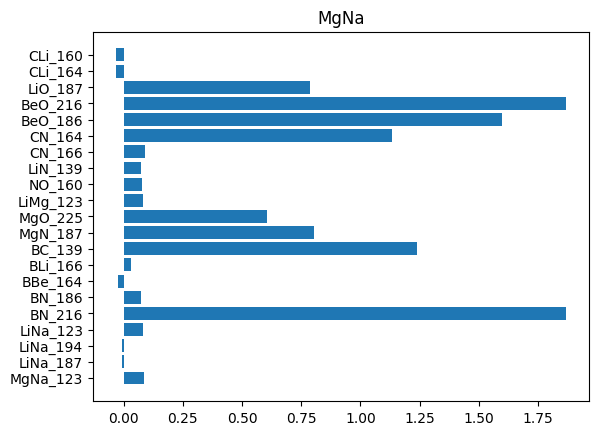

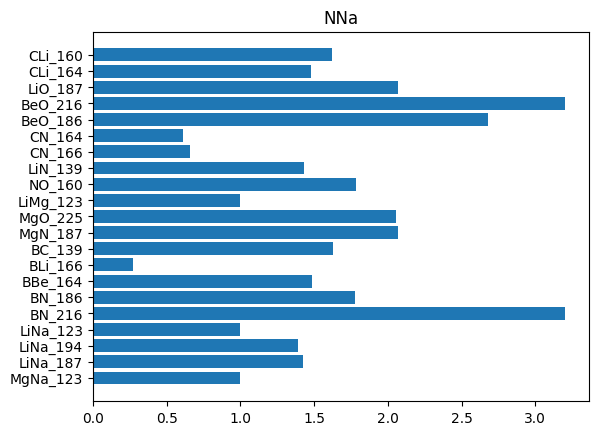

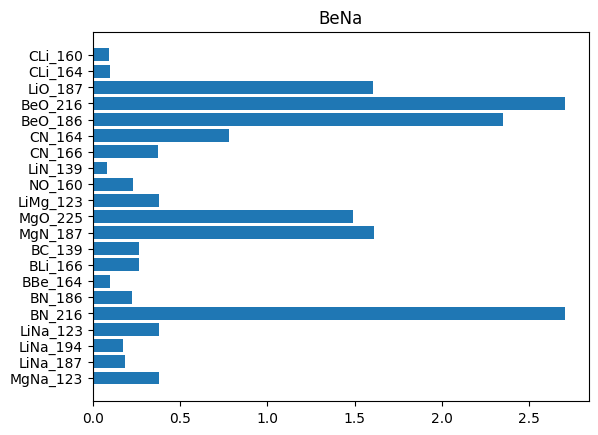

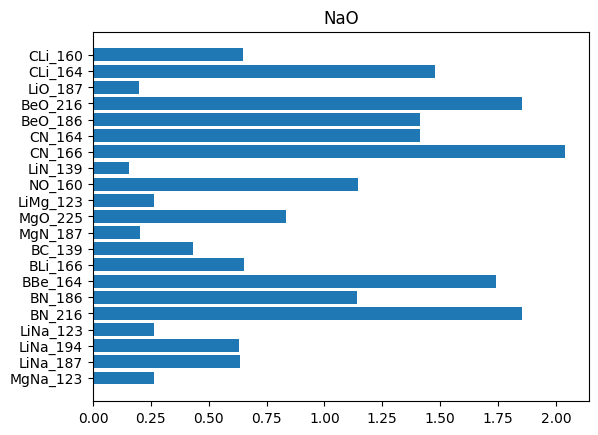

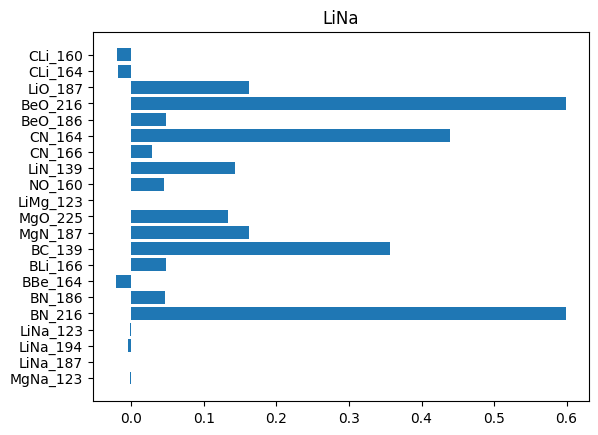

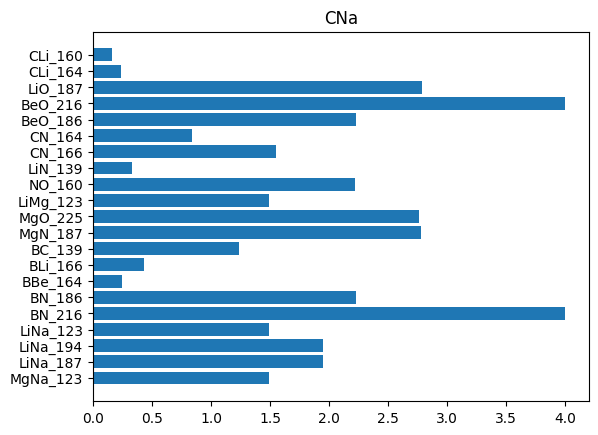

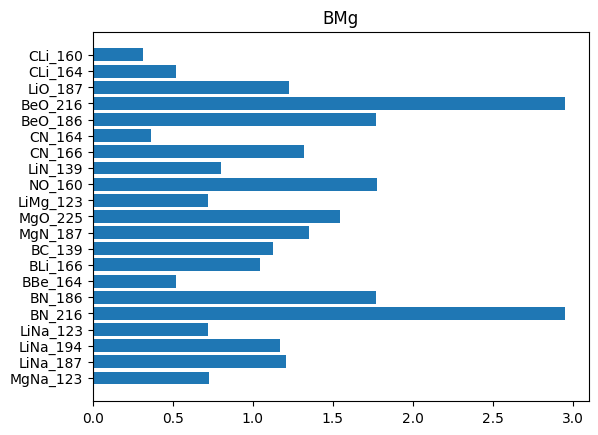

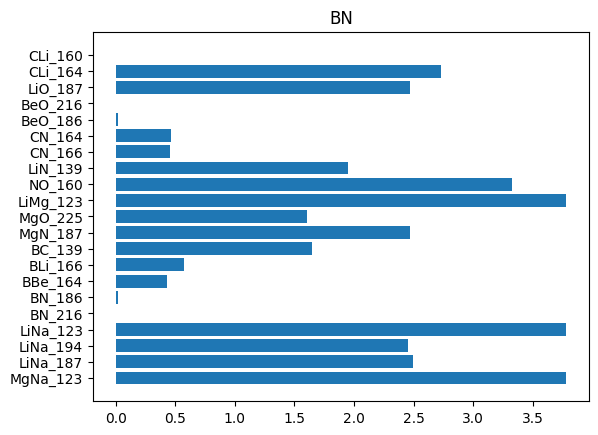

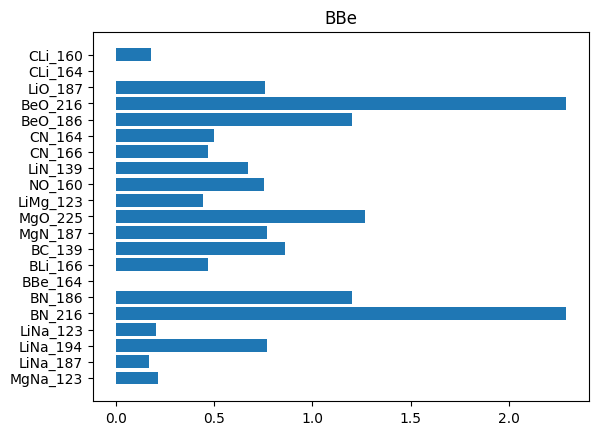

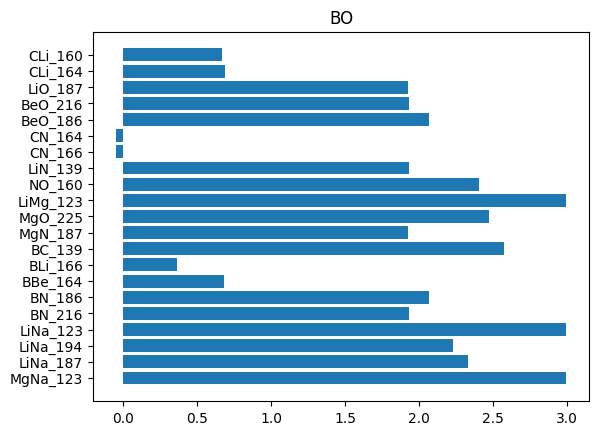

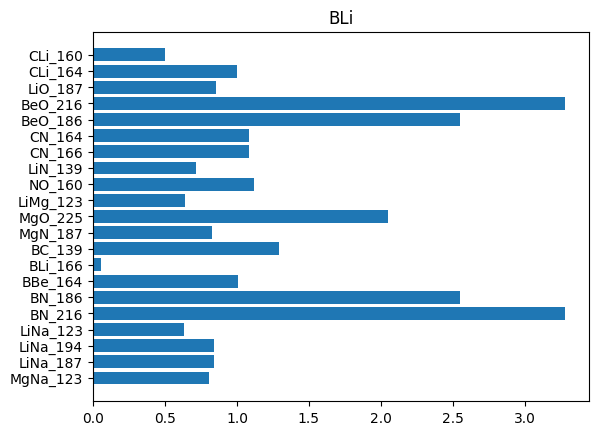

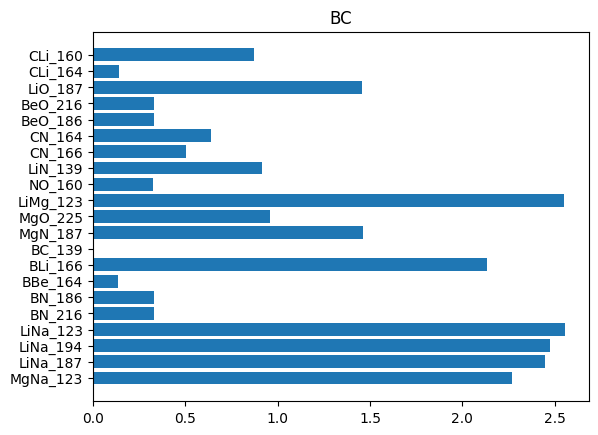

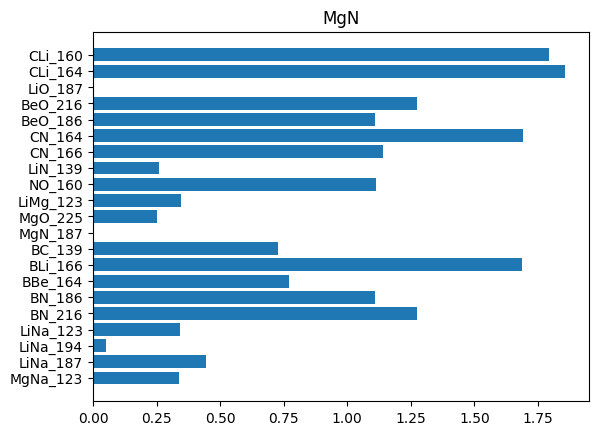

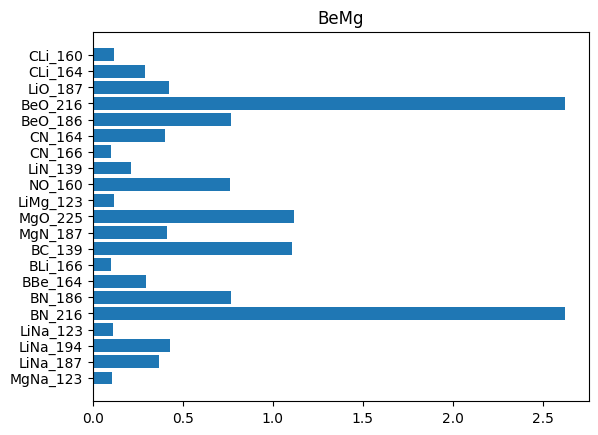

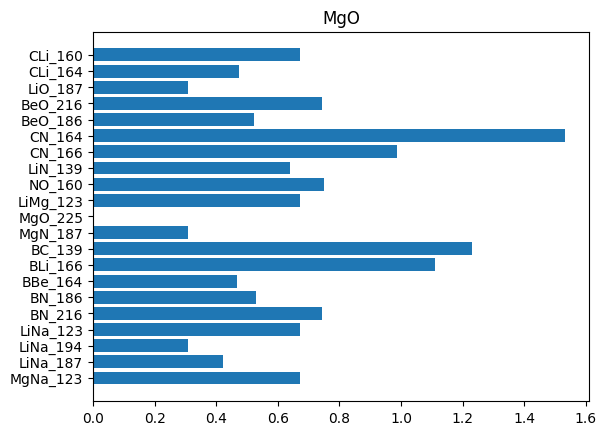

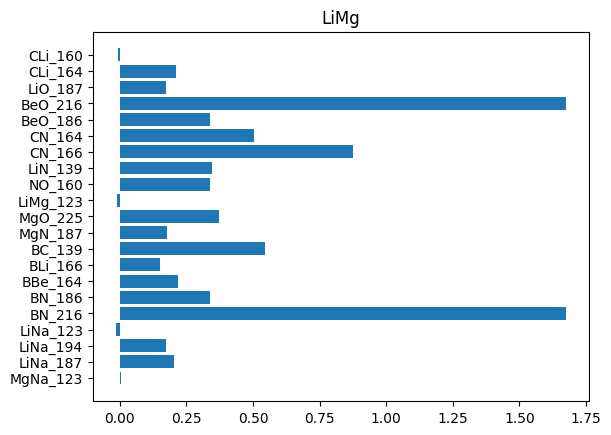

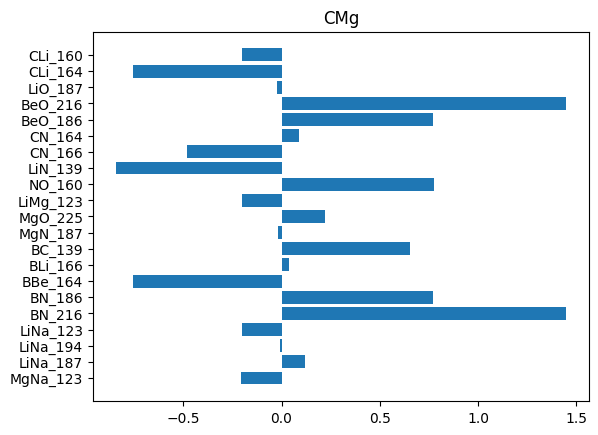

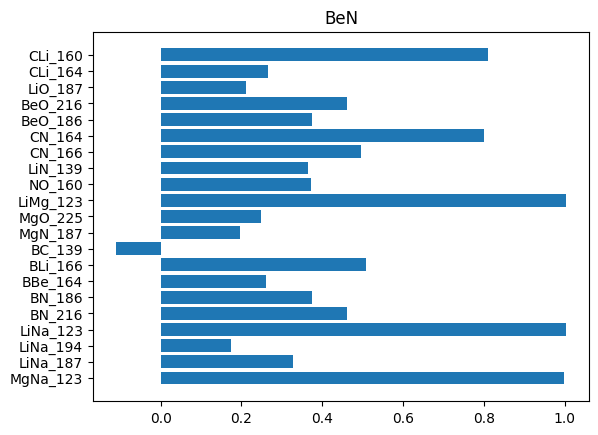

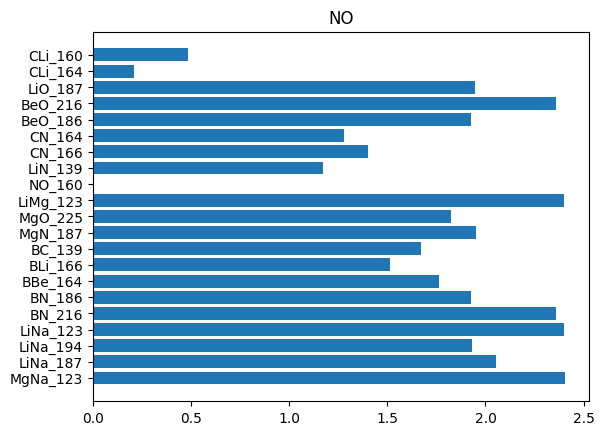

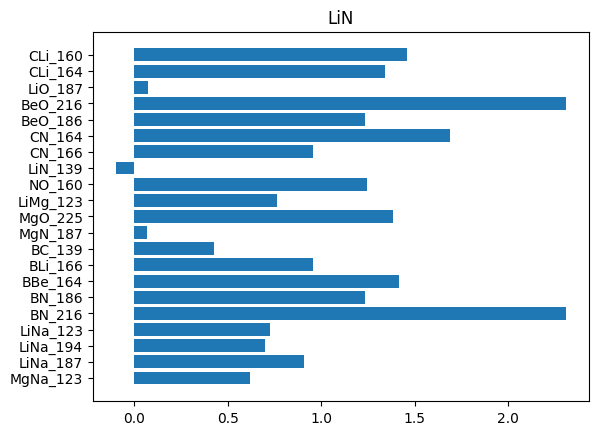

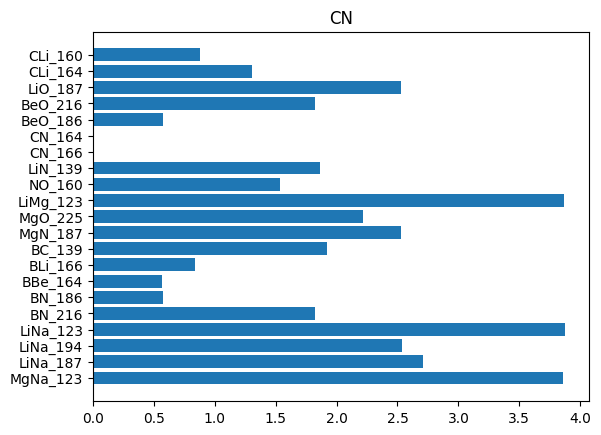

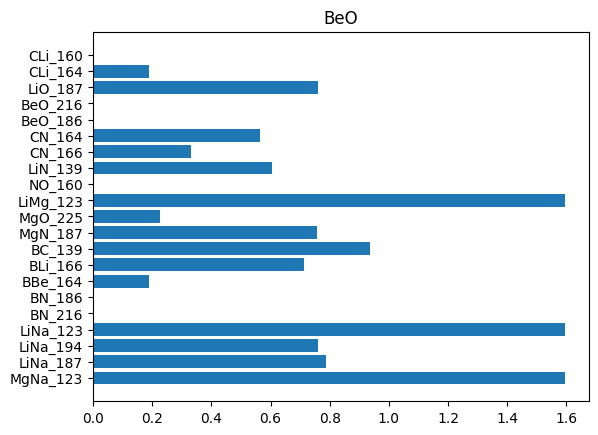

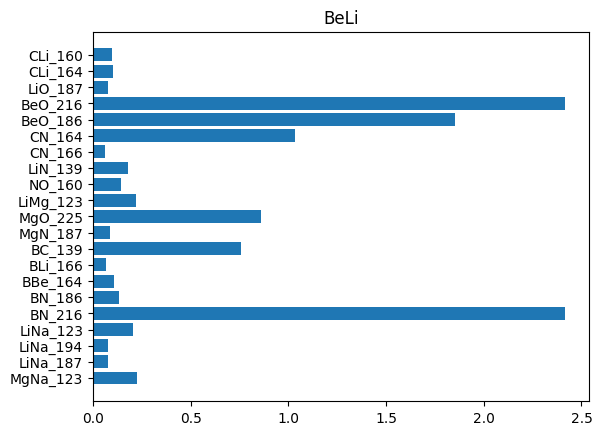

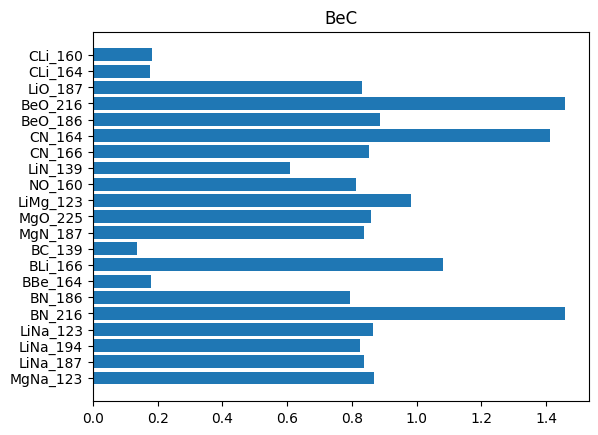

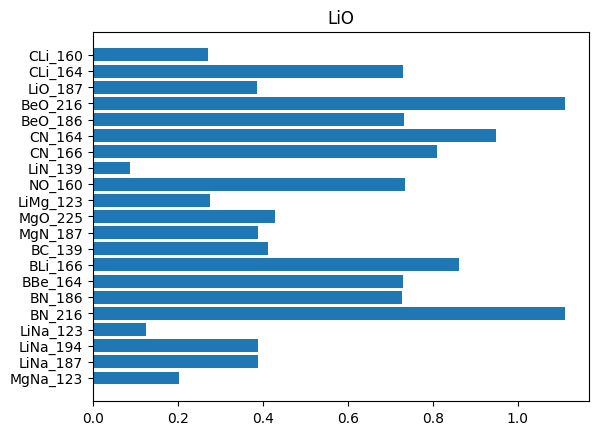

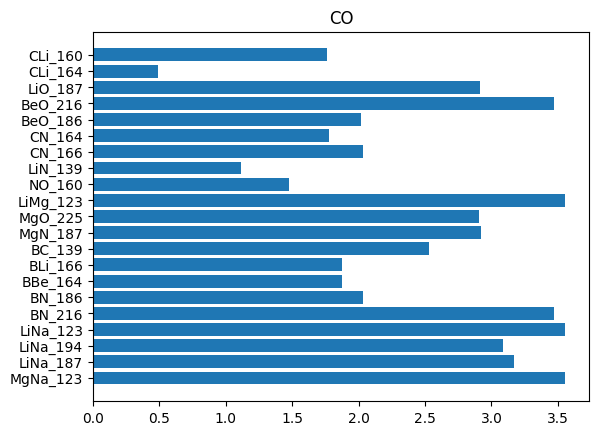

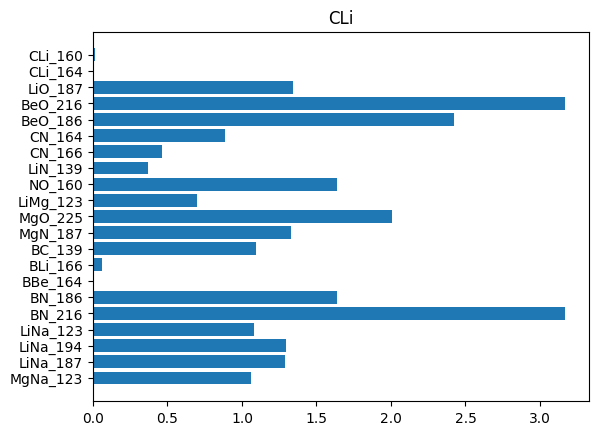

In [6]:
df_gs = pd.read_csv('./AB_relaxation/GroundStates.txt', header=None)
df_temp = pd.read_csv('./AB_relaxation/RELAX_DATA', header=None)
ticks_labels = []
for i in range(1,22):
    ticks_labels.append(df_temp.loc[0,i])

for i in range(1,29):
    diff = np.zeros(21)
    for j in range(1,22):
        diff[j-1] = float(df_temp.loc[i,j])-float(df_gs[df_gs[0]==df_temp.loc[i,0]][1].values[0])
    plt.barh(np.arange(1,22), diff)
    plt.title(df_temp.loc[i,0])
    plt.yticks(np.arange(1,22), ticks_labels)
    plt.show()

# GRAFICI


In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import dendrogram, linkage

In [6]:
x = np.arange(1,22,1)
with open('IMPORTANT_RESULTS.txt' , 'r') as file_data:
    content = file_data.readlines()

for line in content:
    if line.startswith('MEANS:'):
        means = np.array([float(x) for x in line[line.find('[')+1:line.find(']')].split()])
    if line.startswith('STDS:'):
        std = np.array([float(x) for x in line[line.find('[')+1:line.find(']')].split()])


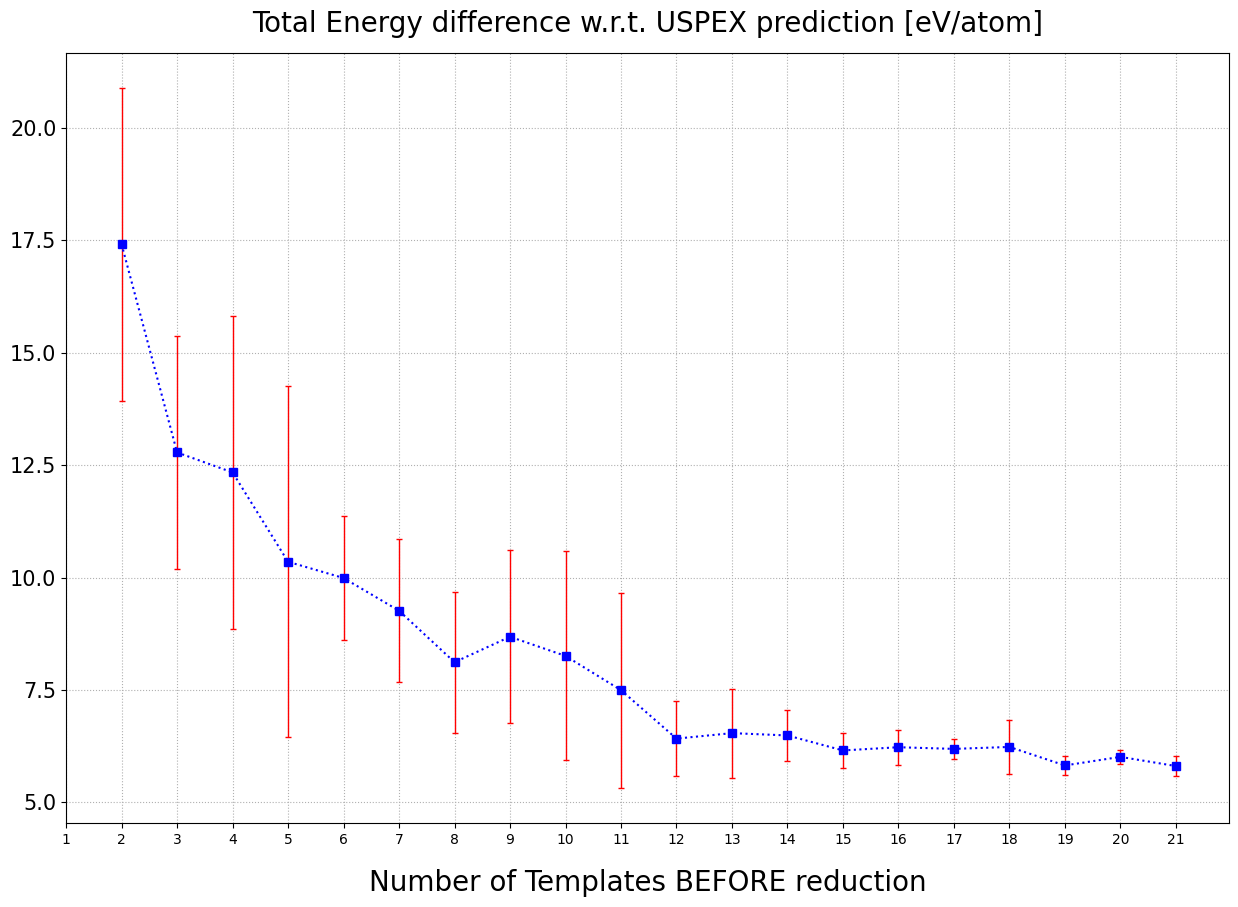

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.errorbar(x[1:], means[1:], yerr=std[1:], fmt='bs:', ecolor='red', elinewidth=1, capsize=2)

ax.set_xlabel('Number of Templates BEFORE reduction', fontsize=20)
ax.set_title('Total Energy difference w.r.t. USPEX prediction [eV/atom]', fontsize=20, pad=15)

ax.xaxis.set_label_coords(0.5, -0.06)
ax.yaxis.set_label_coords(-0.08, 0.5)

ax.grid(True, ls=':')

ax.set_xticks(x)
y_ticks  = np.arange(5,22.5,2.5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=15)


plt.show()

cartella =  '/home/seraf/PRESENTATION'
nome = 'TotalErrors.png'

fig.savefig(os.path.join(cartella, nome))